# AB testing for Google Ads

When downloading data from Google Ads, the option selected must be csv

### Step 1: Load Google Ads data to a dataframe

In [12]:
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Replace 'path_to_csv' with the actual path to your CSV file on Google Drive
path_to_csv = '/content/drive/My Drive/googleads_ab_test_project/googleads_data_alltime5.csv'

# Read CSV data into a DataFrame, skipping the first two rows
df = pd.read_csv(path_to_csv, skiprows=2)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Step 2: Filter the campaigns and columns needed for the A/B test

In [13]:
# Selecting only certain columns
selected_columns = ['Campaign','Clicks', 'Conversions','Conv. rate']
df_selected = df[selected_columns]

# Filtering rows with certain values in a specific column
values_to_filter = ['CoolSculpting: Ventas - LANDING', 'Martinez2 - Tratamientos']  # Add the values you want to filter for
filtered_rows = df_selected[df_selected['Campaign'].isin(values_to_filter)]

# Display the filtered DataFrame
print(filtered_rows)


                           Campaign  Clicks Conversions Conv. rate
12  CoolSculpting: Ventas - LANDING  52,586    2,405.33      4.58%
70         Martinez2 - Tratamientos  38,910    1,884.30      4.84%


### Step 3: Change data types from string to numeric

In [14]:
print(filtered_rows.dtypes)


Campaign       object
Clicks         object
Conversions    object
Conv. rate     object
dtype: object


In [15]:
# Convert Clicks and Conversions columns to float in the filtered_rows DataFrame
filtered_rows['Clicks'] = pd.to_numeric(filtered_rows['Clicks'].str.replace(',', ''), errors='coerce')
filtered_rows['Conversions'] = pd.to_numeric(filtered_rows['Conversions'].str.replace(',', ''), errors='coerce')

# Remove the '%' sign and convert Conv. rate column to float in the filtered_rows DataFrame
filtered_rows['Conv. rate'] = pd.to_numeric(filtered_rows['Conv. rate'].str.rstrip('%'), errors='coerce') / 100

# Display the filtered_rows DataFrame with updated data types
print(filtered_rows.dtypes)

Campaign        object
Clicks           int64
Conversions    float64
Conv. rate     float64
dtype: object


<ipython-input-15-b1cea1335d81>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_rows['Clicks'] = pd.to_numeric(filtered_rows['Clicks'].str.replace(',', ''), errors='coerce')
<ipython-input-15-b1cea1335d81>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_rows['Conversions'] = pd.to_numeric(filtered_rows['Conversions'].str.replace(',', ''), errors='coerce')
<ipython-input-15-b1cea1335d81>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

### Step 4: Setting up the A/B Test

In [16]:
print(filtered_rows)


                           Campaign  Clicks  Conversions  Conv. rate
12  CoolSculpting: Ventas - LANDING   52586      2405.33      0.0458
70         Martinez2 - Tratamientos   38910      1884.30      0.0484


The conversion rate for Martinez2 - Tratamientos is slightly higher than the one in CoolSculpting: Ventas - LANDING.

 The hypothesis test can be expresed as:

 Null Hypothesis (H0):

Conversion rate of "Martinez2 - Tratamientos" - conversion rate of CoolSculpting: Ventas - LANDING." <= 0

Alternative Hypothesis (H1):


Conversion rate of "Martinez2 - Tratamientos" - conversion rate of CoolSculpting: Ventas - LANDING." > 0

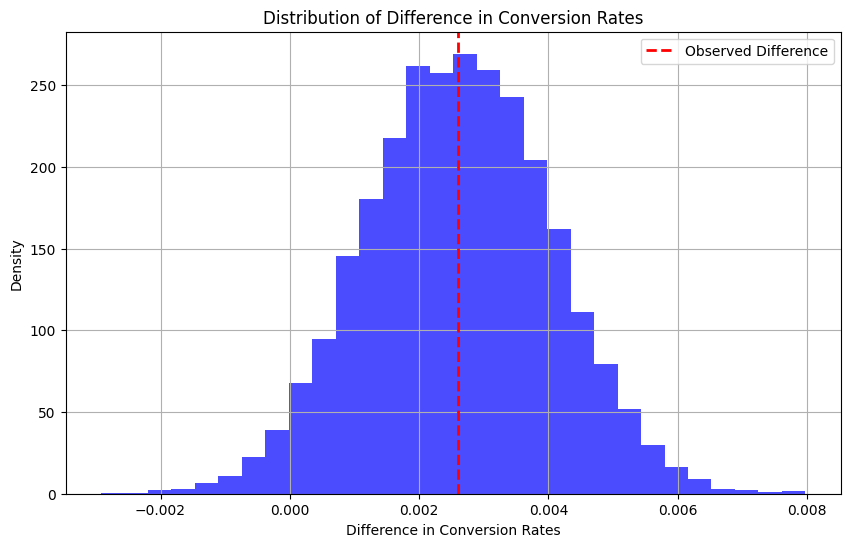

Observed Difference in Conversion Rates: 0.002599999999999998
Simulated p-value: 0.5043
Fail to reject the null hypothesis. Insufficient evidence to support the alternative hypothesis.


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you already have the filtered_rows DataFrame created

# Extract relevant data
n_trials = filtered_rows['Clicks'].values
success_rates = filtered_rows['Conv. rate'].values

# Calculate observed difference in conversion rates
obs_diff_conversion_rate = success_rates[1] - success_rates[0]

# Simulate conversions using binomial distribution
num_simulations = 10000
simulated_conversions = np.zeros((num_simulations, len(n_trials)))

for i in range(num_simulations):
    conversions = np.random.binomial(n_trials, success_rates)
    simulated_conversions[i, :] = conversions

# Calculate conversion rates for simulations
simulated_conversion_rates = simulated_conversions / n_trials.reshape(1, -1)

# Calculate the difference in conversion rates
diff_conversion_rates = simulated_conversion_rates[:, 1] - simulated_conversion_rates[:, 0]

# Calculate the p-value
p_value = (diff_conversion_rates > obs_diff_conversion_rate).mean()

# Plotting the distribution of the differences
plt.figure(figsize=(10, 6))
plt.hist(diff_conversion_rates, bins=30, density=True, color='blue', alpha=0.7)
plt.axvline(x=obs_diff_conversion_rate, color='red', linestyle='dashed', linewidth=2, label='Observed Difference')
plt.xlabel('Difference in Conversion Rates')
plt.ylabel('Density')
plt.title('Distribution of Difference in Conversion Rates')
plt.legend()
plt.grid(True)
plt.show()

print("Observed Difference in Conversion Rates:", obs_diff_conversion_rate)
print("Simulated p-value:", p_value)

# Compare p-value with significance level (e.g., 0.05)
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis. There's enough evidence to support the alternative hypothesis.")
else:
    print("Fail to reject the null hypothesis. Insufficient evidence to support the alternative hypothesis.")


Based on the simulation results, the observed difference in conversion rates is not statistically significant, and the difference could have occurred due to random chance. Hence, it is not clear that one campaign has a better conversion rate than the other one.

## How to calculate how long we should run the experiment?

We can calculate how many observations we need for our experiment,or for how long we should run our experiment, by specifying effect size, alpha and power.

Power: In statistics, power refers to the probability of correctly rejecting the null hypothesis when it is false. A power of 80%, means there is an 80% chance of correctly rejecting the null hypothesis when it is false.

Level of effect: Sometimes you not only need a difference in an experiment to be statistically significant, you also need it to be practically significant, in the sense that you need a level of effect. For example, in the case below, we need at least a change in the conversion rate from 4% to 6%, to we profitable to implement the new solution.

Alpha: A Type I error occurs when we reject the null hypothesis when it is actually true. An alpha level of 5% means that we are willing to accept a 5% chance of making a Type I error.

Given these conditions, we can calculate how many clicks we would need to make an a/b test with determined levels of alpha, power and effect size:

In [1]:
# example of using statsmodels for sample size calculation
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize

# leave out the "nobs" parameter to solve for it
NormalIndPower().solve_power(effect_size = proportion_effectsize(.06, .04), alpha = .05, power = 0.8,
                             alternative = 'larger')

1453.9988419757435

We would need approximately 726 clicks per group at least (1453/2)

Another way to calculate this is with the following tool:
https://abtestguide.com/calc/

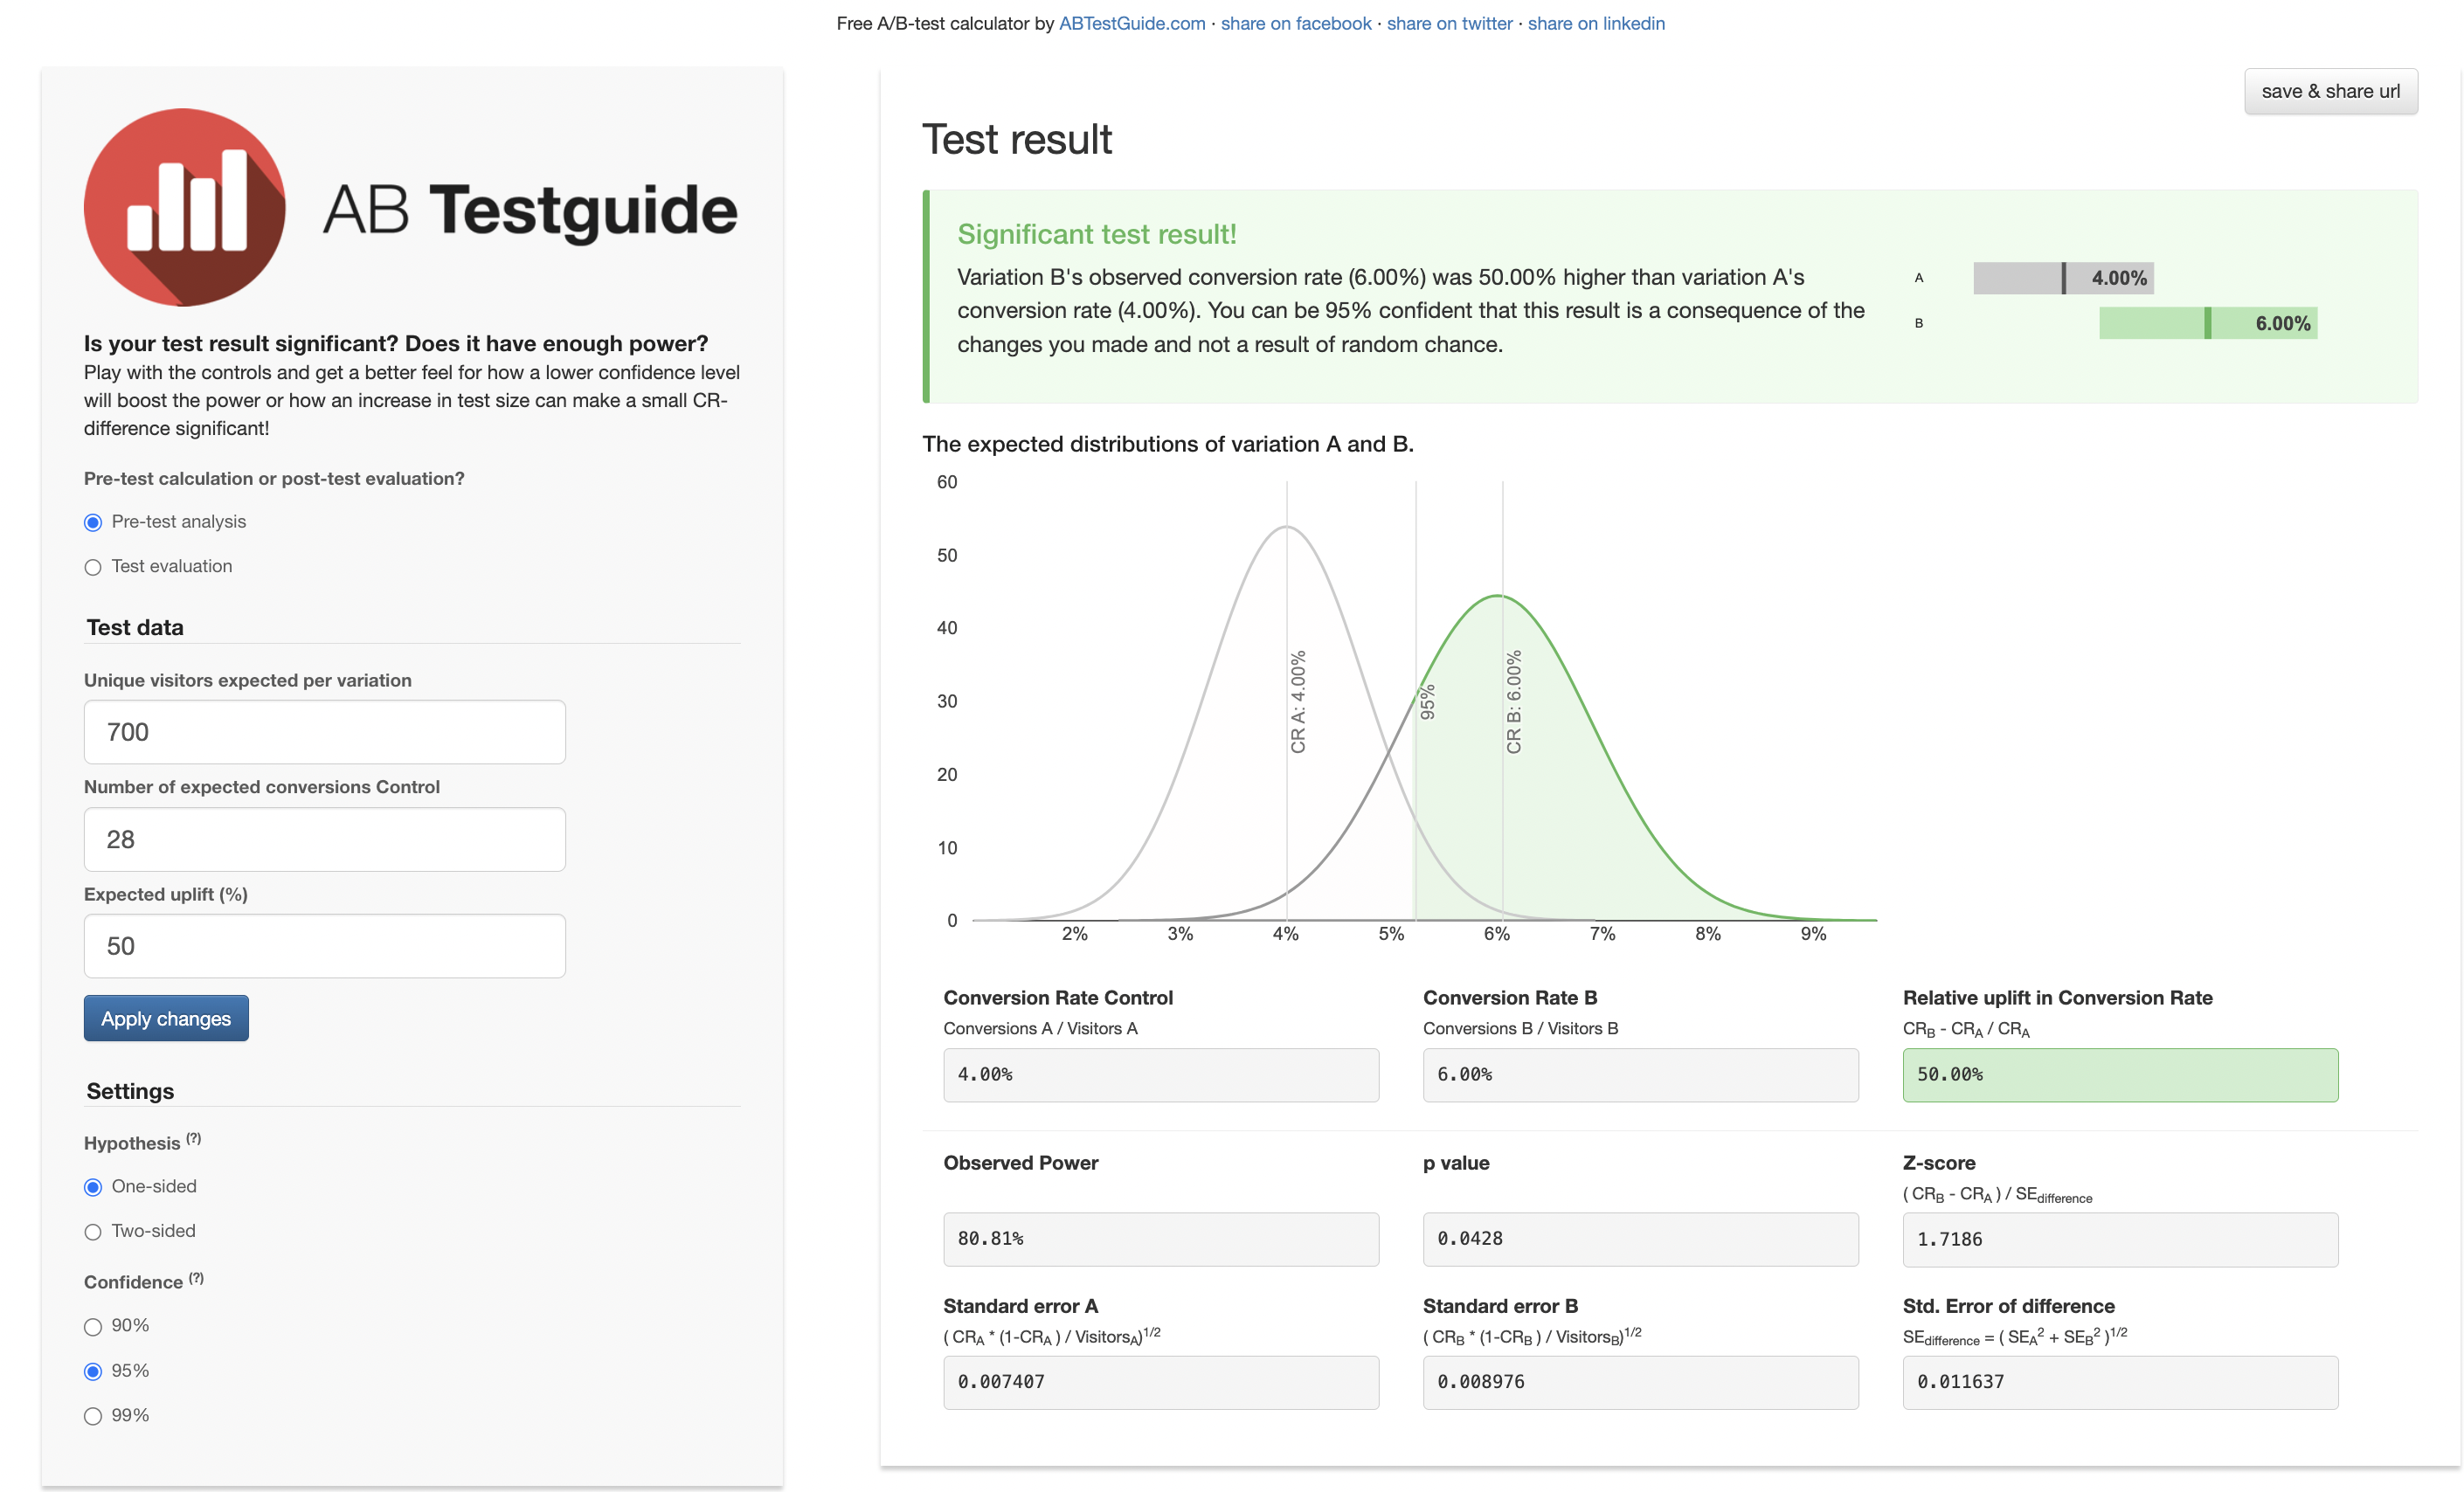

If we are planning on doing an experiment that takes 1 week, we should generate 1453 / 7 = 207 clicks per day approximately.